# Soluzione B

Soluzione proposta utilizzando EfficientNetB2 senza inizializzazione dei pesi
ma riaddestrandolo completamente.

In [1]:
import numpy as np
import pandas as pd
import tensorflow
import os
import tqdm
import skimage.io
import glob
import random
import cv2
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

##Caricamento Dataset

Inizializzazione del dataset importato direttamente da Kaggle.

Nome dataset: [leukemia-classification](https://www.kaggle.com/andrewmvd/leukemia-classification)

Proprietario dataset: andrewmvd


In [2]:
! pip install -q kaggle

###Caricamento JSON con token kaggle

{'kaggle.json': b'{"username":"nome-utente","key":"keyboard-cat"}'}


In [ ]:
from google.colab import files 
files.upload()

In [4]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d andrewmvd/leukemia-classification

 99% 856M/867M [00:27<00:00, 79.2MB/s]
100% 867M/867M [00:27<00:00, 33.0MB/s]


In [ ]:
! unzip leukemia-classification.zip

Esempio di immagine appartenente alla classe All (Malate)

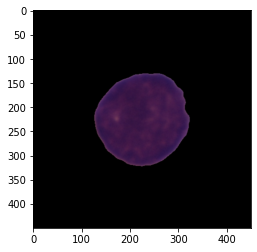

In [8]:
img = mpimg.imread('C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp')
imgplot = plt.imshow(img)
plt.show()

Esempio di immagine appartenente alla classe Hem (Sane)

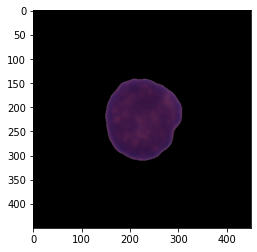

In [9]:
img = mpimg.imread('C-NMC_Leukemia/training_data/fold_2/hem/UID_H13_11_1_hem.bmp')
imgplot = plt.imshow(img)
plt.show()

## Inizializzazione immagini

In [14]:
if os.path.exists("./leukemia-classification.zip"):
  os.remove("./leukemia-classification.zip")
# elimino file non utilizzabili (test set non etichettato)
delete_test_file = glob.glob('./C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/*.bmp')
for file in delete_test_file:
  os.remove(file)

train_dataset_0_all = glob.glob('./C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob('./C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob('./C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob('./C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob('./C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob('./C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

valid_data = pd.read_csv('./C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

Definizione proprietà delle immagini

In [15]:
#Dimensioni immagini per EfficientNetB3
IMAGE_WIDTH = 260  
IMAGE_HEIGHT = 260

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

Unione immagini presenti nelle cartelle di train e di validation

In [16]:
inp_test_path = "/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/"
#Dataset
valid_data_all = []
valid_data_hem = []

dataset_all = train_dataset_0_all + train_dataset_1_all + train_dataset_2_all
dataset_hem = train_dataset_0_hem + train_dataset_1_hem + train_dataset_2_hem 

#Label
valid_label_all = []
valid_label_hem = []
label_all =  ["1" for x in range(len(dataset_all))] 
label_hem = ["0" for x in range(len(dataset_hem))] 


for index, row in valid_data.iterrows():
  if row['labels'] == 0:
    valid_data_hem.append(inp_test_path + row['new_names'])
    valid_label_hem.append("0")
  else: 
    valid_data_all.append(inp_test_path + row['new_names'])
    valid_label_all.append("1")

dataset = dataset_all + dataset_hem + valid_data_all + valid_data_hem
label = label_all + label_hem + valid_label_all + valid_label_hem

In [17]:
print("Num of image All: " + str(len(dataset_all) + len(valid_data_all)))
print("Num of image Hem: " + str(len(dataset_hem) + len(valid_data_hem)))
print("Total image: " + str(len(dataset))) #Train + valid original

Num of image All: 8491
Num of image Hem: 4037
Total image: 12528


## Image Pre-processing

In [18]:
def plot2Image(image, image2):
  plt.figure(figsize = (10, 10))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.subplot(1, 2, 2)
  plt.imshow(image2)
  plt.tight_layout()
  plt.show()

In [19]:
def bbox_center_crop(image, size=(450,450)):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY);
  retval, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
  contours,hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, 2)
  x,y,w,h = cv2.boundingRect(contours[0])
  x,y = x + (size[0] // 2), y + (size[1] // 2)
  new_image = cv2.copyMakeBorder(image, size[1] // 2,size[1] // 2,size[0] // 2,size[0] // 2, cv2.BORDER_CONSTANT, value=[0,0,0])                  
  bbox_center_x = x + (w//2)
  bbox_center_y = y + (h//2)
  x = bbox_center_x - (size[0]//2)
  y = bbox_center_y - (size[1]//2)
  return new_image[y : y + size[1], x : x + size[0], :]

In [20]:
with tensorflow.device('/device:GPU:0'):
  for filename in tqdm(dataset):
    img = imread(filename)
    cropped = bbox_center_crop(img, IMAGE_SIZE)
    imsave(filename, cropped)

100%|██████████| 12528/12528 [03:04<00:00, 68.05it/s]


Esempio di immagine dopo aver effettato l'operazione di cropping.

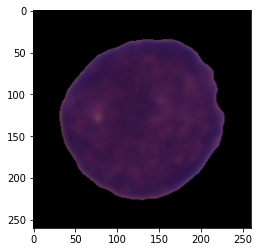

In [17]:
img = mpimg.imread('C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp')
imgplot = plt.imshow(img)
plt.show()

## Data Augmetation
In questa fase vengono aumentate le immagini del training set e del validation set, apportando delle modifiche a delle immagini già presenti al loro interno.

Le operazioni effettuate sono 

1.   Rotazione 
2.   Flip (verticale o orizontale)
3.   Shearing
4.   Gaussian blur


In [8]:
TOTAL_SAMPLE_IN_TRAIN = 10000
TOTAL_SAMPLE_IN_VALIDATION = 2000
random.seed(42)

In [9]:
def removeBackground(image):
    if len(image.shape)==3:
        mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _,mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(mask, 1, 2)
        c = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        return image[y:y+h, x:x+w, :]
    elif len(image.shape)==2:
        _,mask = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(mask, 1, 2)
        c = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        return image[y:y+h, x:x+w]

In [10]:
def shearImage(image, s=(0.1, 0.35)):
    shearV = round(np.random.uniform(s[0], s[1]), 2)
    shearMatrix_X = np.array([[1.0, shearV, 0.0],
                              [0.0, 1.0, 0.0],
                              [0.0, 0.0, 1.0]])
    shearV = round(np.random.uniform(s[0], s[1]), 2)
    shearMatrix_Y = np.array([[1.0, 0.0, 0.0],
                              [shearV, 1.0, 0.0],
                              [0.0, 0.0, 1.0]])
    img = cv2.copyMakeBorder(image,225,225,225,225,cv2.BORDER_CONSTANT,value=[0,0,0])
    height, width, _ = img.shape
    shearAxis = np.random.choice([-1, 0, 1])
    if shearAxis==-1:
        img = cv2.warpPerspective(img, shearMatrix_X, (height,width))
    elif shearV==1:
        img = cv2.warpPerspective(img, shearMatrix_Y, (height,width))
    else:
        img = cv2.warpPerspective(img, shearMatrix_X, (height,width))
        img = cv2.warpPerspective(img, shearMatrix_Y, (height,width))
    img = removeBackground(img)
    w, h, _ = img.shape
    img = cv2.copyMakeBorder(img, (IMAGE_WIDTH//2)+1, (IMAGE_WIDTH//2)+1,
                                  (IMAGE_HEIGHT//2)+1, (IMAGE_HEIGHT//2)+1,
                                  cv2.BORDER_CONSTANT,value=[0,0,0])
    newW, newH, _ = img.shape
    
    img = img[(newH // 2) - IMAGE_HEIGHT // 2 : (newH // 2) + IMAGE_HEIGHT // 2,
              (newW // 2) - IMAGE_WIDTH // 2 : (newW // 2) + IMAGE_WIDTH // 2 , :]
    return img

In [11]:
data_augmentation = tensorflow.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=42),
  layers.experimental.preprocessing.RandomRotation(0.16, fill_mode= "constant", fill_value=.0, seed=42)
])

def augmentImage(image):
  rnd = np.random.uniform(0.0, 1.0)
  image2 = tensorflow.expand_dims(image, 0)
  rotate_flipped = data_augmentation(image2)[0].numpy()
  if rnd < 0.5:
    return rotate_flipped
  elif rnd >= 0.5 and rnd < 0.66:
    return shearImage(rotate_flipped)
  elif rnd >= 0.66:
    return cv2.GaussianBlur(rotate_flipped,(5,5),0)

In [12]:
out_folder_a = "./C-NMC_Leukemia/training_data/fold_a"
out_folder_all = "./C-NMC_Leukemia/training_data/fold_a/all/"
out_folder_hem = "./C-NMC_Leukemia/training_data/fold_a/hem/"

if not os.path.exists(out_folder_a):
  os.mkdir(out_folder_a, mode=777)

if not os.path.exists(out_folder_all):
  os.mkdir(out_folder_all, mode=777)

if not os.path.exists(out_folder_hem):
  os.mkdir(out_folder_hem, mode=777)

### Dataset Split
Dopo il pre-processing dell'immagine, le immagini vengono divise su tre insiemi: *train*, *valid*, *test*.

Le proporzioni adottate sono: 6-3-1; ovvero nel training set cadranno il 60% delle immagini, il 30% cadranno del validation e le restanti cadranno del test.

Infine il training e il validation verranno aumentati con le tecniche sopra descritte.

In [25]:
def augment(data, nsample = 10000):
  resdata = data.copy(deep=True)
  all = data[data["category"] == "1"]
  hem = data[data["category"] == "0"]
  nsample_all = len(all)
  nsample_hem = len(hem)

  def read_and_augment(row):
    image = cv2.imread(row.iloc[0]["filename"])
    aug = augmentImage(image)
    folder = out_folder_all if  row.iloc[0]["category"] == "1" else out_folder_hem
    imagename = folder + str(j) + '_' + os.path.basename(row.iloc[0]["filename"])
    imsave(imagename, aug)
    return imagename, row.iloc[0]["category"]

  for j in tqdm(range(0, nsample - nsample_all)):
    row = all.sample(axis = 0)
    newFile, label = read_and_augment(row)
    res = {'filename':[newFile], 'category':[label]}
    resdata = resdata.append(pd.DataFrame(res), ignore_index=True)

  print(len(resdata))

  for j in tqdm(range(0, nsample - nsample_hem)):
    row = hem.sample(axis = 0)
    newFile, label = read_and_augment(row)
    res = {'filename':[newFile], 'category':[label]}
    resdata = resdata.append(pd.DataFrame(res), ignore_index=True)
  print(len(resdata))

  return resdata

dataset, label = shuffle(dataset, label)
d = {'filename':dataset, 'category':label}
enteireData = pd.DataFrame(data=d)
train, other = train_test_split(enteireData, test_size = 0.4, random_state = 88, shuffle = True)
valid, test = train_test_split(other, test_size = 0.25, random_state = 88, shuffle = True)


train  = augment(train, 10000)
valid  = augment(valid, 2000)

100%|██████████| 4915/4915 [01:27<00:00, 56.17it/s]


12431


100%|██████████| 7569/7569 [02:13<00:00, 56.70it/s]


20000


0it [00:00, ?it/s]


3759


100%|██████████| 804/804 [00:14<00:00, 57.31it/s]

4563


In [27]:
print("Num of image in training set: " + str(len(train)))
print("Num of image in validation set: " + str(len(valid)))
print("Num of image in test set: " + str(len(test))) 

Num of image in training set: 20000
Num of image in validation set: 4563
Num of image in test set: 1253


Esempio di immage della classe ALL dopo la fase di Augmentation

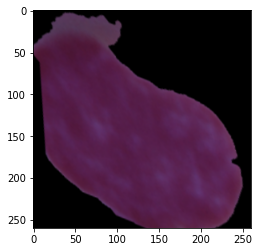

In [32]:
img = mpimg.imread('/content/C-NMC_Leukemia/training_data/fold_a/all/1003_UID_45_16_5_all.bmp')
imgplot = plt.imshow(img)
plt.show()

Esempio di immage della classe HEM dopo la fase di Augmentation

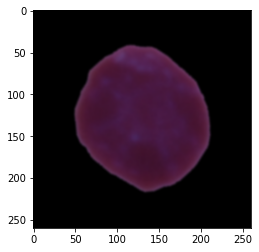

In [33]:
img = mpimg.imread('/content/C-NMC_Leukemia/training_data/fold_a/hem/1008_UID_H12_26_2_hem.bmp')
imgplot = plt.imshow(img)
plt.show()

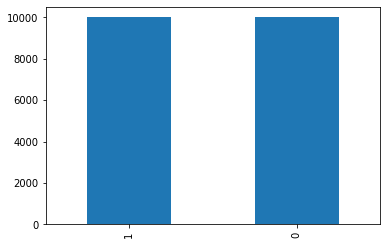

In [ ]:
train['category'].value_counts().plot.bar()

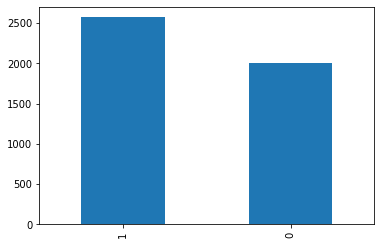

In [ ]:
valid['category'].value_counts().plot.bar()

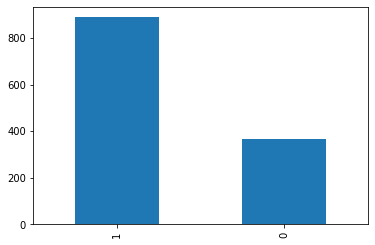

In [ ]:
test['category'].value_counts().plot.bar()

### Initializzazione generatori

Per addestrare il modello facciamo uso di generatori che caricano a runtime le immagini e le forniscono al modello, evitando di saturare la memoria disponibile sulla macchina.

Durante la generazione le immagini vengono riscalate da un intervallo di 0-255 a un intervallo da 0-1.

In [34]:
batch_size = 32

In [35]:
train_datagen = ImageDataGenerator(
     rescale = 1 / 255.0
)

train_generator = train_datagen.flow_from_dataframe(
    train, 
    "./",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)


Found 20000 validated image filenames belonging to 2 classes.


In [36]:
validation_datagen = ImageDataGenerator(
     rescale = 1 / 255.0
)

validation_generator = train_datagen.flow_from_dataframe(
    valid,
    "./",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 4571 validated image filenames belonging to 2 classes.


In [37]:
test_datagen = ImageDataGenerator(
    rescale = 1 / 255.0,
)

test_generator = test_datagen.flow_from_dataframe(
    test,
    "./",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False,
)

Found 1253 validated image filenames belonging to 2 classes.


### Preparazione del modello

In [38]:
total_train = train.shape[0]
total_validate = valid.shape[0]

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras import Model
model_eff = EfficientNetB2(include_top=False, weights=None, input_tensor=None,
                    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), pooling=None, classes=2)
LR_AT_EPOCH0 = 1e-5
kernelReg = regularizers.l1_l2(l1=0.0001, l2=0.0001)
x = model_eff.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=kernelReg)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=kernelReg)(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation="softmax", kernel_regularizer=kernelReg)(x)
model = Model(inputs=model_eff.input, outputs=predictions)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 260, 260, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 260, 260, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 261, 261, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Gradient Descendent Optimizer
LR_AT_EPOCH0=5e-6
from tensorflow.keras import optimizers, regularizers, initializers
opt = optimizers.Adam(learning_rate=LR_AT_EPOCH0, decay=0.0 ,beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Definizione di funzioni di utilità. 

In [ ]:
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/t/EfficientNetB2_v2.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto")
callbacks = [earlystop, learning_rate_reduction, checkpoint]
epochs = 30

## Training del modello - 30 Epoche

In [ ]:
history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks,
)

Epoch 1/30
625/625 [==============================] - 729s 1s/step - loss: 3.8451 - accuracy: 0.5418 - val_loss: 3.8516 - val_accuracy: 0.4375

Epoch 00001: val_accuracy improved from -inf to 0.43754, saving model to /content/gdrive/MyDrive/t/EfficientNetB2_v2.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
625/625 [==============================] - 664s 1s/step - loss: 3.7718 - accuracy: 0.5616 - val_loss: 3.7297 - val_accuracy: 0.5406

Epoch 00002: val_accuracy improved from 0.43754 to 0.54058, saving model to /content/gdrive/MyDrive/t/EfficientNetB2_v2.h5
Epoch 3/30
625/625 [==============================] - 666s 1s/step - loss: 3.7098 - accuracy: 0.5720 - val_loss: 3.6583 - val_accuracy: 0.5699

Epoch 00003: val_accuracy improved from 0.54058 to 0.56990, saving model to /content/gdrive/MyDrive/t/EfficientNetB2_v2.h5
Epoch 4/30
625/625 [==============================] - 666s 1s/step - loss: 3.6468 - accuracy: 0.5890 - val_loss: 3.5908 - val_accuracy: 0.6075

Epoch 00004: val_accuracy improved from 0.56990 to 0.60753, saving model to /content/gdrive/MyDrive/t/EfficientNetB2_v2.h5
Epoch 5/30
625/625 [==============================] - 667s 1s/step - loss: 3.5747 - accuracy: 0.6252 - val_loss: 3.4909 - val_accuracy: 0.6832

Epoch 00005: val_accuracy improved from 0.60753 to 0.68

### Prestazioni del Training

### Training Accuracy e Validation Accuracy

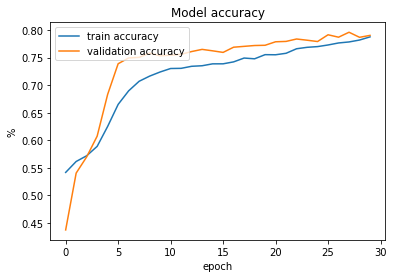

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("%")
plt.xlabel("epoch")
plt.legend(["train accuracy","validation accuracy"], loc="upper left")
plt.show()

#### Training Loss a Validation Loss

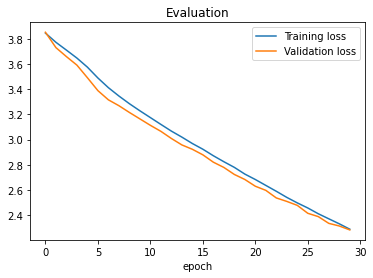

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Evaluation")
plt.ylabel("")
plt.xlabel("epoch")
plt.legend(["Training loss","Validation loss"], loc="upper right")
plt.show()

#### Training Loss a Validation Loss

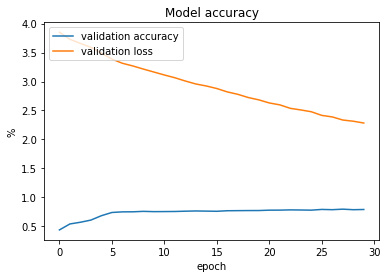

In [ ]:
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])
plt.title("Model accuracy")
plt.ylabel("%")
plt.xlabel("epoch")
plt.legend(["validation accuracy","validation loss"], loc="upper left")
plt.show()

## Training modello  - 30

In [27]:
model = tensorflow.keras.models.load_model("/content/gdrive/MyDrive/EfficientNetB2_v2.h5")

In [28]:
#Gradient Descendent Optimizer
LR_AT_EPOCH0=5e-6
from tensorflow.keras import optimizers, regularizers, initializers
opt = optimizers.Adam(learning_rate=LR_AT_EPOCH0, decay=0.0 ,beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 1, verbose = 1, factor = 0.5, min_lr = 0.000001)
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/t/EfficientNetB2_v3.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto")
callbacks = [earlystop, learning_rate_reduction, checkpoint]
epochs = 30

## Valutazione prestazioni
In questa fase vengono valutate le prestazioni del modello addestrato utilizzando il Test set.

La peculiarità del test set è che non vien mai visto dal modello durante la fase di training.

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title = 'Confusion matrix',
                          cmap = None,
                          normalize = True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.show()

Confusion Matrix


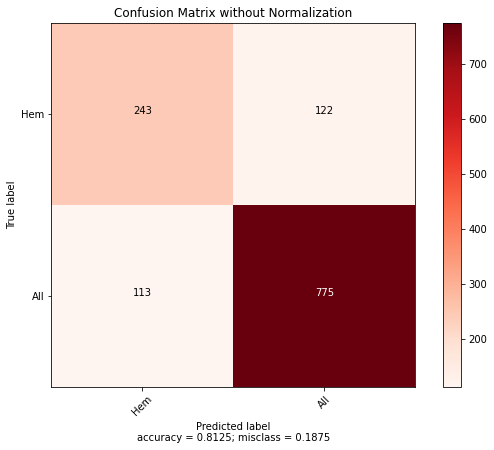

Classification Report
              precision    recall  f1-score   support

         Hem       0.68      0.67      0.67       365
         All       0.86      0.87      0.87       888

    accuracy                           0.81      1253
   macro avg       0.77      0.77      0.77      1253
weighted avg       0.81      0.81      0.81      1253



In [ ]:
print('Confusion Matrix')

plot_confusion_matrix(cm = confusion_matrix(test_generator.classes, y_pred), 
                            normalize = False,
                            target_names = ['Hem', 'All'],
                            title = "Confusion Matrix without Normalization")

print('Classification Report')
target_names = ['Hem', 'All']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))